# Exp NBD: DONE

In [1]:
import numpy as np

with open("g7.td") as f:
    for i, line in enumerate(f):
        if line.strip() == "#DATA":
            start = i + 1
            break

data = np.loadtxt("g7.td", skiprows=start)
print(data[:5])
print(data[-5:])

# time [s]
# Intensity Floureszenz

print(data.shape)

[[ 0.2      94.535   ]
 [ 0.4      94.264333]
 [ 0.6      94.262666]
 [ 0.8      94.379666]
 [ 1.       94.208666]]
[[5399.4       172.133   ]
 [5399.6       171.97    ]
 [5399.8       171.989   ]
 [5400.        172.068333]
 [5400.2       172.376   ]]
(27001, 2)


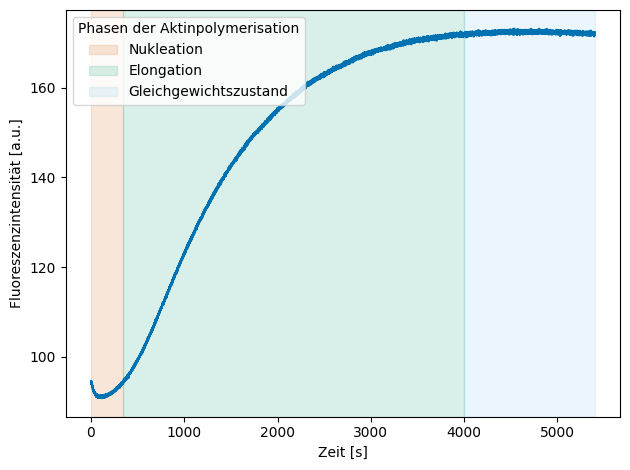

In [2]:
import matplotlib.pyplot as plt

x = data[:, 0]
y = data[:, 1]

plt.figure()
plt.plot(x, y, color="#0072B2", label="Messdaten")

# ---- FARBBEREICHE ----
lag = plt.axvspan(0, 343, color='#D55E00', alpha=0.15, label="Nukleation")
exp = plt.axvspan(343, 4000, color='#009E73', alpha=0.15, label="Elongation")
plateau = plt.axvspan(4000, 5400, color='#56B4E9', alpha=0.12, label="Gleichgewichtszustand")

# ---- ACHSEN ----
plt.xlabel("Zeit [s]")
plt.ylabel("Fluoreszenzintensität [a.u.]")

# ---- LEGENDE ----
plt.legend(handles=[lag, exp, plateau], loc="upper left", title="Phasen der Aktinpolymerisation")

plt.tight_layout()
plt.show()

#"Exponentielle Phase, Sättigungphase

Fit-Parameter:
A  = 66.5893350777561
B  = 172.3518214631469
k  = 0.0015732868418308814
t0 = 939.5574430212994


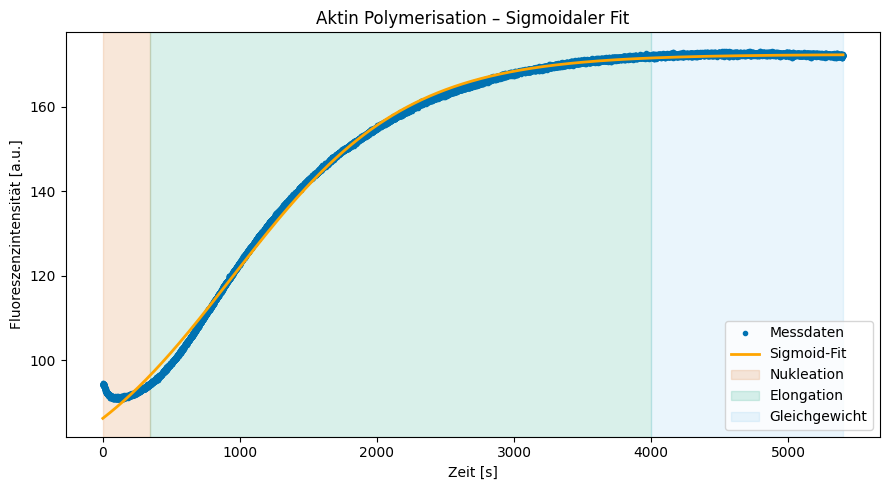

R² = 0.9981254291482554
RMSE = 1.1512201991524766


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------- DATEN LADEN ----------
with open("g7.td") as f:
    for i, line in enumerate(f):
        if line.strip() == "#DATA":
            start = i + 1
            break

data = np.loadtxt("g7.td", skiprows=start)

t = data[:, 0]  # Zeit [s]
I = data[:, 1]  # Fluoreszenzintensität

# ---------- SIGMOID-FUNKTION ----------
def sigmoid(t, A, B, k, t0):
    return A + (B - A) / (1 + np.exp(-k * (t - t0)))

# ---------- STARTWERTE ----------
A0 = np.min(I)
B0 = np.max(I)
t0_0 = t[np.argmax(np.diff(I))]   # grobe Schätzung
k0 = 0.001                        # flache Kinetik, langsam steigende Fluoreszenz

p0 = [A0, B0, k0, t0_0]

# ---------- FIT ----------
params, cov = curve_fit(sigmoid, t, I, p0=p0, maxfev=20000)
A_fit, B_fit, k_fit, t0_fit = params

print("Fit-Parameter:")
print("A  =", A_fit)
print("B  =", B_fit)
print("k  =", k_fit)
print("t0 =", t0_fit)

# ---------- GLATTE FITKURVE ----------
t_fit = np.linspace(t.min(), t.max(), 2000)
I_fit = sigmoid(t_fit, *params)

# ---------- PLOT ----------
plt.figure(figsize=(9, 5))
plt.plot(t, I, ".", color="#0072B2", label="Messdaten")
plt.plot(t_fit, I_fit, "-", color="orange", linewidth=2, label="Sigmoid-Fit")

# ---- FARBBEREICHE ----
plt.axvspan(0, 343, color='#D55E00', alpha=0.15, label="Nukleation")
plt.axvspan(343, 4000, color='#009E73', alpha=0.15, label="Elongation")
plt.axvspan(4000, 5400, color='#56B4E9', alpha=0.12, label="Gleichgewicht")

# ---- ACHSEN ----
plt.xlabel("Zeit [s]")
plt.ylabel("Fluoreszenzintensität [a.u.]")
plt.title("Aktin Polymerisation – Sigmoidaler Fit")

# ---- LEGENDE ----
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()
I_pred = sigmoid(t, *params)

In [3]:
I_pred = sigmoid(t, *params)

# R²
SS_res = np.sum((I - I_pred)**2)
SS_tot = np.sum((I - np.mean(I))**2)
R2 = 1 - SS_res / SS_tot

# RMSE
RMSE = np.sqrt(np.mean((I - I_pred)**2))

print("R² =", R2)
print("RMSE =", RMSE)


R² = 0.9981254291482554
RMSE = 1.1512201991524766
